In [1]:
using StaticArrays
# using Plots
using LinearAlgebra
# using Makie
using GLMakie 
using LsqFit
include("Elastic.jl")
using .Elastic
using FFMPEG
using DelimitedFiles
using Distributions

In [2]:
atom_positions = [
    Vector([0.0, 0.0, 0.0]),
    Vector([0.0, 0.5, 0.5]),
    Vector([0.5, 0.0, 0.5]),
    Vector([0.5, 0.5, 0.0]),
    Vector([1.0, 0.0, 0.0]),
    Vector([0.0, 1.0, 0.0]),
    Vector([0.0, 0.0, 1.0]),
    Vector([0.5, 1.0, 0.5]),
    Vector([1.0, 0.5, 0.5]),
    Vector([0.5, 0.5, 1.0]),
    Vector([1.0, 0.0, 1.0]),
    Vector([1.0, 1.0, 0.0]),
    Vector([0.0, 1.0, 1.0]),
    Vector([1.0, 1.0, 1.0])
] 

# 创建铜的原子列表
atoms = [Atom(pos) for pos in atom_positions]
#lj势能
function lj(r::Float64)
    return 4*(1/r^12-1/r^6)
end
function Flj(r::Vector{Float64})
    rn=norm(r)
    return 24*(2/rn^14-1/rn^8)*r
end

ct=5.0
interaction = Interaction(lj, Flj, ct, 0.1)
Ts=1.0
Ps=10.0
inicell=initcell(Ps,Ts,atoms,interaction,cp=[3,3,3],Prg=[0.03,10])


MethodError: MethodError: no method matching *(::UnitCell, ::Int64)

Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:587
  *(!Matched::ChainRulesCore.NoTangent, ::Any)
   @ ChainRulesCore C:\Users\ASUS\.julia\packages\ChainRulesCore\6Pucz\src\tangent_arithmetic.jl:64
  *(::Any, !Matched::ChainRulesCore.NotImplemented)
   @ ChainRulesCore C:\Users\ASUS\.julia\packages\ChainRulesCore\6Pucz\src\tangent_arithmetic.jl:38
  ...


In [3]:
visualize_unitcell_atoms0(inicell,iftext=true)

In [3]:
pressure_int(inicell,interaction)

9.99443377111503043003612705993865831876204754712112392774994690576715491774433

In [5]:
force_tensor(inicell,interaction)

3×3 Matrix{Float64}:
 13.9891    -0.385165  -1.6301
 -0.385165   8.64875   -1.20679
 -1.6301    -1.20679    9.62894

[15024:26104:1014/205453.024:ERROR:t_skinfilemap.cpp(63)] SGRenderLog:CheckUpdate newMem.OpenMem Suc, szNewMem:Local\sgime_skin.v3.filemap.sogouime
[15024:26104:1014/205453.024:ERROR:t_skinfilemap.cpp(65)] SGRenderLog:CheckUpdate finish: old version:1
[15024:26104:1014/205453.024:ERROR:t_skinfilemap.cpp(67)] SGRenderLog:CheckUpdate finish: new version:3


In [6]:
function Rk3(cell::UnitCell,interaction::Interaction,thermostat::Thermostat,barostat::Barostat,dt::Float64,nstep::Int64;dumpstep::Int64=100)
    z=cell2z(cell,thermostat,barostat);
    for i=1:dumpstep
        k1=Hz(z,cell,interaction,thermostat,barostat)
        zr=z+(dt/2).*k1
        update_cell!(zr,cell)
        k2=Hz(zr,cell,interaction,thermostat,barostat)
        zr=z-dt.*k1+(2*dt).*k2
        update_cell!(zr,cell)
        k3=Hz(zr,cell,interaction,thermostat,barostat)
        z.=z+(dt/6).*(k1.+4*k2.+k3)
        update_cell!(z,cell)
        pint=pressure_int(cell,interaction)
        T=cell_temp(cell)
    if i%dumpstep==0
        println("step: ",i," Temp: ",T," Pressure: ",pint)
    end
    end
end

Rk3 (generic function with 1 method)

In [7]:

# using JLD2

# # 打开文件并读取内容
# file_path = "dumpcell.jld2"
# data = JLD2.jldopen(file_path, "r") do file
#     # 创建一个字典来存储所有数据
#     Dict(name => read(file, name) for name in keys(file))
# end

# cell=data["cell_1000"]

In [9]:
function pressure_int0(cell::UnitCell,interaction::Interaction,dUdV::T=dUdV_default) where T
    v=cell.Volume
    Pint1=0.0
    Pint2=0.0
    lt=cell.lattice_vectors
    for i in 1:length(cell.atoms)
        atom=cell.atoms[i]
        pm=atom.momentum
        ri=lt*atom.position
        fi=cell_forcei(cell,interaction,i)
        Pint1+=dot(pm,pm)/atom.mass
        Pint2+=dot(ri,fi)
    end
    println("Pint1=$Pint1,Pint2=$Pint2")
    Pint=Pint1+Pint2
    return Pint/v/3
end

pressure_int0 (generic function with 2 methods)

In [10]:
cell=deepcopy(inicell)
dt=0.01
natom=length(cell.atoms)
Qs=3*natom*Ts*(30*dt)^2
Ws=3*natom*Ts*(1000*dt)^2
thermostat = Thermostat(Ts, Qs, 0.0, 0.0)
barostat=Barostat(Ps,Ws,cell.Volume,0.0)
pl=[]
Tl=[]
z=cell2z(cell,thermostat,barostat);
for i in 1:10
k1=Hz(z,cell,interaction,thermostat,barostat)
zr=z+(dt/2).*k1
update_cell0!(zr,cell)
k2=Hz(zr,cell,interaction,thermostat,barostat)
zr=z-dt.*k1+(2*dt).*k2
update_cell0!(zr,cell)
k3=Hz(zr,cell,interaction,thermostat,barostat)
z.=z+(dt/6).*(k1.+4*k2.+k3)
update_cell0!(z,cell)
pint=pressure_int(cell,interaction)
T=cell_temp(cell)
if mod(i,1)==0
V0=cell.Volume
println("step: ",i," Temp: ",T," Pressure: ",pint," Volume: ",V0)
end
push!(pl,pint)
push!(Tl,T)
end


UndefVarError: UndefVarError: `update_cell0!` not defined

In [12]:
cell=deepcopy(inicell)
dt=0.01
natom=length(cell.atoms)
Qs=3*natom*Ts*(30*dt)^2
Ws=3*natom*Ts*(1000*dt)^2
thermostat = Thermostat(Ts, Qs, 0.0, 0.0)
barostat=Barostat(Ps,Ws,cell.Volume,0.0)
pl=[]
Tl=[]
z=cell2z(cell,thermostat,barostat);
for i in 1:10
RK3_step0(z,dt,cell,interaction,thermostat,barostat)
end


UndefVarError: UndefVarError: `RK3_step0` not defined

In [15]:
# inicell.lattice_vectors=inicell.lattice_vectors*1.01
pressure_int0(inicell,interaction)
# pressure_int0(inicell,interaction)
# println(inicell.lattice_vectors)
# println(cell.lattice_vectors)

UndefVarError: UndefVarError: `dUdV_default` not defined

In [16]:
function update_cell0!(z::Vector{Float64},cell::UnitCell)
    natom=Int((length(z)-4)/6)
    rl=z[1:3*natom]
    pl=z[3*natom+3:3*natom+3*natom+3]

###这里是否需要修改体积还有待考虑，现在加了p会向-inf发散  
    v=z[3*natom+2]
    v0=cell.Volume
    if v<0
        println("v<0 at v=$v")
    end
    ap=((v/v0)^(1/3)) 
    ltm=cell.lattice_vectors*ap  
    cell.lattice_vectors=ltm
    cell.Volume=v
    a,b,c=cell.copy
    # z[1:3*natom].=z[1:3*natom]
    # z[3*natom+3:3*natom+3*natom+3].=z[3*natom+3:3*natom+3*natom+3]
#####################
    for i in 1:natom
        ri=inv(cell.lattice_vectors)*rl[3*i-2:3*i]
        ri[1]=mod(ri[1],a)
        ri[2]=mod(ri[2],b)
        ri[3]=mod(ri[3],c)
        cell.atoms[i].position=ri
        cell.atoms[i].momentum=pl[3*i-2:3*i]
    end
end

update_cell0! (generic function with 1 method)

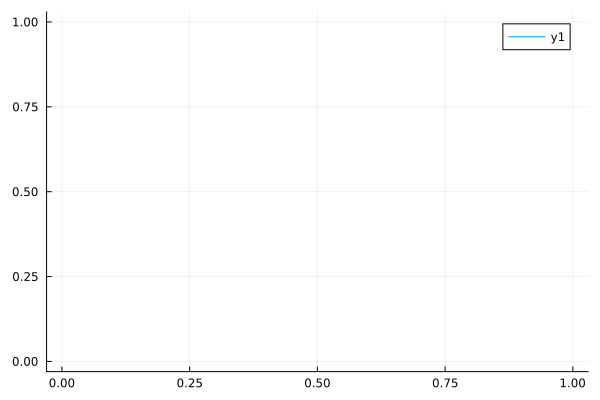

In [17]:
using Plots
y=pl
Plots.plot(1:length(y),y)


In [18]:
function RK3_step0(z::Vector{Float64},dt::Float64,cell::UnitCell, interaction::Interaction, thermostat::Thermostat, barostat::Barostat;kb::Float64=1.0)
k1=Hz(z,cell,interaction,thermostat,barostat)
zr=z+(dt/2).*k1
update_cell0!(zr,cell)
k2=Hz(zr,cell,interaction,thermostat,barostat)
zr=z-dt.*k1+(2*dt).*k2
update_cell0!(zr,cell)
k3=Hz(zr,cell,interaction,thermostat,barostat)
z.=z+(dt/6).*(k1.+4*k2.+k3)
update_cell0!(z,cell)
pint=pressure_int(cell,interaction)
T=cell_temp(cell)
V0=cell.Volume
println(" Temp: ",T," Pressure: ",pint," Volume: ",V0)
end

RK3_step0 (generic function with 1 method)

In [19]:
cell=deepcopy(inicell)
thermostat = Thermostat(Ts, 1000.0, 0.0, 0.0)
barostat=Barostat(Ps,1000.0,cell.Volume,0.0)
RK3_step0!(z,dt,cell,interaction,thermostat,barostat)
pressure_int(cell,interaction)
cell


UndefVarError: UndefVarError: `RK3_step0!` not defined

In [11]:
cell=deepcopy(inicell)
dt=0.01
natom=length(cell.atoms)
Qs=3*natom*Ts*(30*dt)^2
Ws=3*natom*Ts*(1000*dt)^2
thermostat = Thermostat(Ts, Qs, 0.0, 0.0)
barostat=Barostat(Ps,Ws,cell.Volume,0.0)
pl=[]
Tl=[]
z=cell2z(cell,thermostat,barostat);


In [29]:
# W=barostat.W
# Q=thermostat.Q
# vk0=0.0
# ve0=0.0
# eps0=0.0
# kbb=1.0



# rl=fill(zeros(3),natom)
# pl=fill(zeros(3),natom)
# fl0=fill(zeros(3),natom)
# Al=zeros(natom)
# natom=length(cell.atoms)
# Pe=barostat.Pe
# Pint0=pressure_int(cell,interaction)
# V0=cell.Volume
# Fe0=3*V0*(Pint-Pe)
# for i in 1:natom
# Fe0+=dot(cell.atoms[i].momentum,cell.atoms[i].momentum)/cell.atoms[i].mass
# end

# Gk=(3*natom+1)*kb*T/Q+W/Q*ve0^2
# for i in 1:natom
#     Gk+=dot(cell.atoms[i].momentum,cell.atoms[i].momentum)/cell.atoms[i].mass/Q
# end
# kdt=k0+vk0*dt+Gk

# epsdt=eps0+ve0*dt+(Fe/W-ve0*vk0)dt^2/2
# ltv=cell.lattice_vectors
# invlt=inv(ltv)
# for i in 1:natom
#     ri0=ltv*cell.lattice_vectors
#     mi=natom.mass
#     vi0=cell.atoms[i].momentum/mi
#     fi0=cell_forcei(cell,interaction,i)
#     ridt=exp(epsdt-eps0)*(ri0+vi0*dt+(fi0/mi-vi0*vk0+(2+1/natom)*vi0*vk0)*dt^2/2)
#     cell.atoms[i].position=invlt*ridt
#     rl[i]=ridt
#     fl0[i]=fi0
# end

# for i in 1:natom
#     ridt=rl[i]
#     fi0=fl0[i]
#     fidt=cell_forcei(cell,interaction,i)
#     Ai=exp(epsdt-eps0)*(fi0/mi-vi0*vk0+(2+1/natom)*vi0*vk0)*dt/2+fidt*dt/2
#     Al[i]=Ai
# end

# Fedt=3*V0*(Pint-Pe)
# for i in 1:natom
# Fedt+=dot(cell.atoms[i].momentum,cell.atoms[i].momentum)/cell.atoms[i].mass
# end
# for iter in 1:maxiter
#     Gkdt=(3*natom+1)*kb*T/Q+W/Q*ve0^2

# end


# ###迭代待完成

1.0028571840708105

Barostat(0.1, 32400.0, 2093.3143432731626, 0.0)

In [76]:
inicell=initcell(0.1,Ts,atoms,interaction,cp=[3,3,3],Prg=[0.03,8])
inicell


UnitCell([3.5168749999999998 0.0 0.0; 0.0 3.5168749999999998 0.0; 0.0 0.0 3.5168749999999998], Atom[Atom([0.0, 0.0, 0.0], [-1.0838246937134217, 0.6977591051839822, 0.9788425222922291], 1.0, 8, [1, 1, 1]), Atom([0.0, 0.0, 1.0], [-0.9119704096485415, 0.05258469512799331, -0.08944027403197866], 1.0, 4, [1, 1, 0]), Atom([0.0, 0.0, 2.0], [0.3378397971920997, 0.07021596802261448, 0.6534089209563397], 1.0, 4, [1, 1, 0]), Atom([0.0, 1.0, 0.0], [-2.4998773781699906, 0.5548185278489415, 1.4333045487812963], 1.0, 4, [1, 0, 1]), Atom([0.0, 1.0, 1.0], [0.8348388102176484, 1.441934256684436, 0.7658482188943121], 1.0, 2, [1, 0, 0]), Atom([0.0, 1.0, 2.0], [0.9411417041463863, -0.6353212371259962, -1.2246448061634083], 1.0, 2, [1, 0, 0]), Atom([0.0, 2.0, 0.0], [0.3244234682378346, 1.1578193754068102, -2.242380680865527], 1.0, 4, [1, 0, 1]), Atom([0.0, 2.0, 1.0], [-0.16196899235898365, -0.5285133849685386, -0.3802934628243643], 1.0, 2, [1, 0, 0]), Atom([0.0, 2.0, 2.0], [0.2343757795658778, -0.7372445188

In [75]:
pressure_int(inicell,interaction)

0.9958098807882965

In [ ]:
Ts=1.0
Ps=10.0
dt=0.001
dt2=dt/2

const I = 1.0  # 假设 I 的值为 1.0，需根据实际情况调整

const E2 = I / 6.0
const E4 = E2 / 20.0
const E6 = E4 / 42.0
const E8 = E6 / 72.0

Tl=[]
pl=[]
celllist=[]
inicell=initcell(Ps,Ts,atoms,interaction,cp=[5,5,5],Prg=[1.0,6.0])
cell=deepcopy(inicell)
natom=length(inicell.atoms)
Qs=3*natom*Ts*(10*dt)^2
Ws=3*natom*Ts*(100*dt)^2
thermostatchain = [Thermostat(Ts, Qs, 0.0, 0.0) for i in 1:20]
for i in 2:length(thermostatchain)
thermostatchain[i].Q=Qs/natom/3
end

barostat=Barostat(Ps,Ws,cell.Volume,0.0)
dt2=dt/2
natom=length(cell.atoms)

W=barostat.W


for step in 1:10000
Nhcpisoint!(cell,interaction,thermostatchain,barostat,dt)
xlogv=1/3*log(barostat.V)
vlogv=barostat.Pv
initial_volume=cell.Volume
# println(xlogv)
for i in 1:natom
fi=cell_forcei(cell,interaction,i)
mi=cell.atoms[i].mass
cell.atoms[i].momentum.+=dt2*fi
end
AA=exp(dt2*vlogv)
AA2=AA*AA
# println(vlogv)
arg2=(vlogv*dt2)^2
poly=(((E8*arg2+E6)*arg2+E4)*arg2+E2)+I
BB=AA*poly*dt
invltv=inv(cell.lattice_vectors)
for i in 1:natom
    # println("atom:$i,pos:$(cell.atoms[i].position),$AA2,$((BB)*(invltv*cell.atoms[i].momentum/cell.atoms[i].mass))")
    cell.atoms[i].position.=cell.atoms[i].position*AA2+(BB)*(invltv*cell.atoms[i].momentum/cell.atoms[i].mass)
    # println("atom:$i,pos:$(cell.atoms[i].position),$AA2,$((BB)*(invltv*cell.atoms[i].momentum/cell.atoms[i].mass))")
end

xlogv=xlogv+vlogv*dt
cell.Volume=exp(3*xlogv)
cell.lattice_vectors=cell.lattice_vectors*(cell.Volume/initial_volume)^(1/3)
barostat.V=cell.Volume
barostat.Pv=vlogv
for i in 1:natom
fi=cell_forcei(cell,interaction,i)
mi=cell.atoms[i].mass
cell.atoms[i].momentum.+=dt2*fi
end

# println("step: ",step," Temp: ",cell_temp(cell)," Pressure: ",pressure_int(cell,interaction)," Volume: ",cell.Volume)

Nhcpisoint!(cell,interaction,thermostatchain,barostat,dt)

cp=cell.copy
for i in 1:natom 
    for j in 1:3
        cell.atoms[i].position[j]=mod(cell.atoms[i].position[j],cp[j])
    end
end


push!(Tl,cell_temp(cell))
push!(pl,pressure_int(cell,interaction))
push!(celllist,deepcopy(cell))
if mod(step,100)==0
println("step: ",step," Temp: ",cell_temp(cell)," Pressure: ",pressure_int(cell,interaction)," Volume: ",cell.Volume)
end
end

step: 100 Temp: 0.947130947505888 Pressure: 8.796860612979154275446163036125682696395500480972565466312826840238448008810075 Volume: 440.82472412460027
step: 200 Temp: 0.99543415780896 Pressure: 8.755844599874377527059131631286832075378840168098216263182403842839414303542346 Volume: 460.75582148198885


In [86]:
visualize_unitcell_atoms(cell)

In [4]:

function Nhcpisoint!(cell::UnitCell,interaction::Interaction,thermostatchain::Vector{Thermostat},barostat::Barostat,dt::Float64)
    kb=1.0
    natom=length(cell.atoms)
    Nf=3*natom
    T=thermostatchain[1].T
    GN1KT=(Nf+1)*kb*T
    GNKT=Nf*kb*T
    GKT=kb*T
    odnf=1+3/Nf
    W=barostat.W
    V=cell.Volume
    Pe=barostat.Pe
    Pint=pressure_int(cell,interaction)
    nnos=length(thermostatchain) ##恒温器数量3个
    glogs=zeros(nnos)
    vlogs=[th.Pt for th in thermostatchain]
    xlogs=[th.Rt for th in thermostatchain]
    xlogv=1/3*log(barostat.V)
    vlogv=barostat.Pv
    glogv=0.0

    
    nresn=3  #3*3差分 nresn->nc，第一次多步
    nyosh=3           #nyosh->nys 第二维多步
    w1=1/(2-2^(1/3))
    w3=w1
    w2=1-2*w1
    wdti=[w1,w2,w3]*dt
    wdti2=wdti./2/nresn
    wdti4=wdti./4/nresn
    wdti8=wdti./8/nresn

    
    scale::BigFloat=1.0
    kint=0.0
    for i in 1:natom 
        kint=kint+dot(cell.atoms[i].momentum,cell.atoms[i].momentum)/cell.atoms[i].mass
    end
    # println("kint=$kint")
        glogs[1]=(kint+W*vlogv^2-GN1KT)/thermostatchain[1].Q
        # println("glogs=$glogs")
        glogv=(odnf*kint+3.0*(Pint-Pe)*V)/W
        # println(W*vlogv^2)
        # println(vlogv^2)
        # println(GN1KT)
        # println(thermostatchain[1].Q)
    for iresn in 1:nresn 
        for iyosh in 1 :nyosh
                   
            vlogs[nnos]=vlogs[nnos]+glogs[nnos]*wdti4[iyosh]
            
            for inos in 1:nnos-1
                AA=exp(-wdti8[iyosh]*vlogs[nnos+1-inos])
                vlogs[nnos-inos]=vlogs[nnos-inos]*AA^2+wdti4[iyosh]*glogs[nnos-inos]*AA
            end
            AA=exp(-wdti8[iyosh]*vlogs[1])
            # println(vlogs)

            

            vlogv=vlogv*AA^2+wdti4[iyosh]*glogv*AA

            AA=exp(-wdti2[iyosh]*(vlogs[1]+odnf*vlogv))
            # println("scale=$scale,AA=$AA,vlogs=$vlogs")
            scale=scale*AA
            # println("scale=$scale,AA=$AA,vlogs[1]=$(vlogs[1]),vlogv=$vlogv")
            kint=kint*AA^2
            glogv=(odnf*kint+3.0*(Pint-Pe)*V)/W
            
    
            for inos in 1:nnos
                xlogs[inos]=xlogs[inos]+vlogs[inos]*wdti2[iyosh]
            end
            AA=exp(-wdti8[iyosh]*vlogs[1])
            vlogv=vlogv*AA^2+wdti4[iyosh]*glogv*AA
            glogs[1]=(kint+W*vlogv^2-GN1KT)/thermostatchain[1].Q
            
            for inos in 1: nnos-1
                AA=exp(-wdti8[iyosh]*vlogs[inos+1])
                vlogs[inos]=vlogs[inos]*AA*AA+wdti4[iyosh]*glogs[inos]*AA
                glogs[inos+1]=(thermostatchain[inos].Q*vlogs[inos]*vlogs[inos]-GKT)/thermostatchain[inos+1].Q
            end
            vlogs[nnos]=vlogs[nnos]+glogs[nnos]*wdti4[iyosh]
        end

    end

   
    for i in 1:natom 
        cell.atoms[i].momentum=cell.atoms[i].momentum*scale
    end

    # barostat.V=exp(3*xlogv)
    # cell.Volume=barostat.V
    # cell.lattice_vectors=cell.lattice_vectors*(barostat.V/V0)^(1/3)
    # println("V0=$V0,V=$V")
    barostat.Pv=vlogv
    for inos in 1:nnos 
        thermostatchain[inos].Rt=xlogs[inos]
        thermostatchain[inos].Pt=vlogs[inos]
    end
    # println(exp(3*xlogv))
    # println(xlogs)
    # println(vlogs)  
end

Nhcpisoint! (generic function with 1 method)

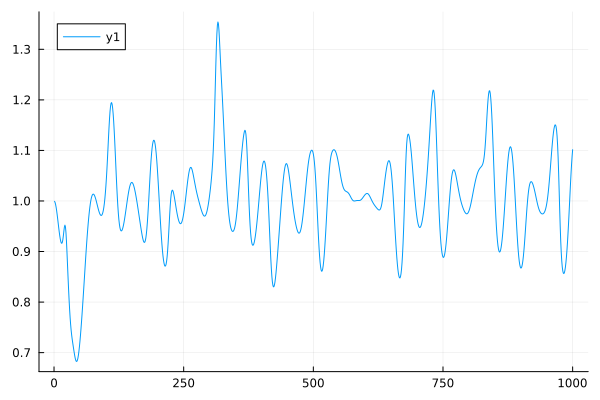

In [19]:
using Plots
Plots.plot(Tl)

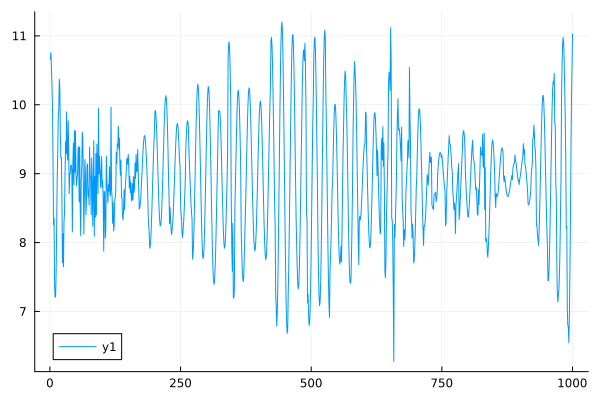

In [18]:
Plots.plot(pl)

In [141]:
outputfold="outputfold"
function func(i)
    newcell=celllist[i]
    fig=visualize_unitcell_atoms(newcell)
    return fig
end
isdir(outputfold) || mkpath(outputfold)
for i in 1:1:100
    fig=func(i)
    save(joinpath(outputfold, "frame$i.png"), fig)
end

In [17]:
del=[]
function test1(initcell)
    for dV in  1e-7:1e-7:1e-5
    natom=length(initcell.atoms)
    V0::BigFloat=inicell.Volume
    dV0::BigFloat=inicell.Volume*dV
    V1=V0+dV0
    V2=V0-dV0
    ltv=inicell.lattice_vectors
    ltv1=inicell.lattice_vectors*(V1/V0)^(1/3)
    ltv2=inicell.lattice_vectors*(V2/V0)^(1/3)

    dcell=deepcopy(inicell)
    dcell.lattice_vectors=ltv1
    for i in natom
    dcell.atoms[i].position=inv(ltv1)*ltv*dcell.atoms[i].position
    end
    energy1=cell_energy0(dcell,interaction)

    dcell=deepcopy(inicell)
    dcell.lattice_vectors=ltv2
    for i in natom
    dcell.atoms[i].position=inv(ltv2)*ltv*dcell.atoms[i].position
    end
    energy2=cell_energy0(dcell,interaction)


    push!(del,(energy1-energy2))
    end
    x=(1.0:length(del))
    xx=x.^(-x)
    Plots.plot(x,del)
end

test1 (generic function with 1 method)

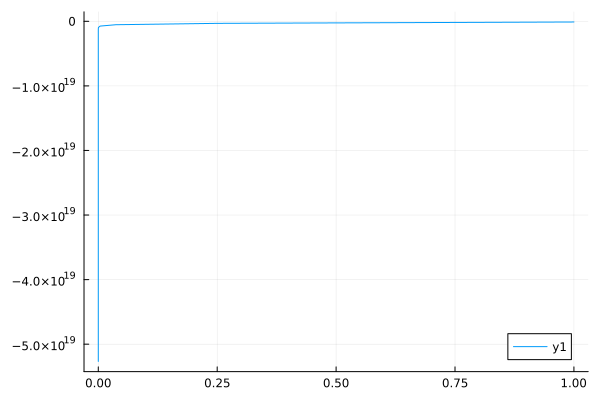

In [15]:
using Plots
x=(1.0:length(del))
xx=x.^(-x)
Plots.plot(xx,del)

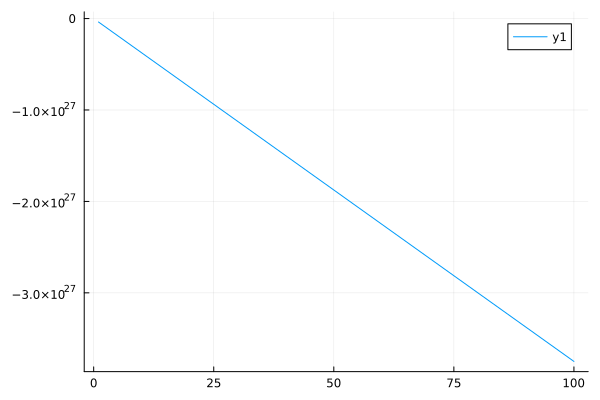

In [18]:
inicell.lattice_vectors=inicell.lattice_vectors*0.4
test1(inicell)

In [ ]:
natom=length(initcell.atoms)
V0::BigFloat=cell.Volume
dV0::BigFloat=cell.Volume*dV
V1=V0+dV0
V2=V0-dV0
ltv=inicell.lattice_vectors
ltv1=inicell.lattice_vectors*(V1/V0)^(1/3)
ltv2=inicell.lattice_vectors*(V2/V0)^(1/3)

dcell=deepcopy(inicell)
dcell.lattice_vectors=ltv1
for i in natom
dcell.atoms[i].position=inv(ltv1)*ltv*dcell.atoms[i].position
end
energy1=cell_energy0(dcell,interaction)

dcell=deepcopy(inicell)
dcell.lattice_vectors=ltv2
for i in natom
dcell.atoms[i].position=inv(ltv2)*ltv*dcell.atoms[i].position
end
energy2=cell_energy0(dcell,interaction)


push!(del,(energy1-energy2)/dV0)
end
x=(1.0:length(del))
xx=x.^(-x)
Plots.plot(x,del)